# 状态空间模型vs机器学习
## 概要

分别选取了时间序列与机器学习的相关算法，对数据（SP100list.csv）分别进行预测，并将预测结果以MAPE和MASE为标准进行比对。

时间序列算法：
1. AR模型（包括单噪声模型（SSOE）和双噪声模型（MSOE））
2. Theta模型
3. Damp Trend模型（包括了单噪声模型（SSOE））

机器学习算法：
1. K临近法（KNN）
2. 回归树（RT）
3. 随机森林（RF/基于回归树)
4. 神经网络（NN）
5. LSTM

## 实例
**构造函数**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
import warnings

# 时间序列算法函数直接参考PDF复现代码
def ForecastMethod_AR(y, h):
    state = 0*np.ones(len(y))
    v = 0*np.ones(len(y))
    state[0] = y[0]

    def logLikConc(myparam):
        w, gamma, co = 1 - math.exp(-abs(myparam[0])), abs(myparam[1]), abs(myparam[2])
        for t in range(1, len(y)):
            v[t] = y[t]-state[t-1]
            state[t] = co+w*state[t-1]+gamma*v[t]
        temp = np.sum(np.power(v[1:len(y)], 2))
        return temp

    result = minimize(logLikConc, [2, .2, 1])
    w, gamma, co = 1 - math.exp(-abs(result.x[0])), abs(result.x[1]), abs(result.x[2])
    for t in range(1, len(y)):
        v[t] = y[t] - state[t - 1]
        state[t] = co + w * state[t - 1] + gamma * v[t]
    Forec = np.array([state[len(y) - 1]])
    for i in range(1, h):
        Forec = np.append(Forec, co + w * Forec[i - 1])
    return Forec


def ForecastMethod_ARkf(y, h):
    n = len(y)
    a, p, k, v = [np.ones(n) for _ in range(4)]
    a[0], p[0] = y[0], 10000

    def fu(mypa):
        q, co, w = abs(mypa[0]), abs(mypa[1]), 1-math.exp(-abs(mypa[2]))
        z = 1
        likelihood = sigmae = 0
        for t in range(1, n):
            k[t] = (z * w * p[t - 1]) / (pow(z, 2) * p[t - 1] + 1)
            p[t] = pow(w, 2) * p[t - 1] - w * z * k[t] * p[t - 1] + q
            v[t] = y[t] - z * a[t - 1]
            a[t] = co + w * a[t - 1] + k[t] * v[t]
            sigmae += (pow(v[t], 2) / (pow(z, 2) * p[t - 1] + 1))
            likelihood += .5 * math.log(2 * math.pi) + .5 + .5 * math.log(pow(z, 2) * p[t - 1] + 1)
        return likelihood + .5 * n * math.log(sigmae / n)

    results = minimize(fu, [.2, 1, 2])
    v[0], z = 0, 1
    q, co, w, sigmae = abs(results.x[0]), results.x[1], 1-math.exp(-abs(results.x[2])), 0
    for t in range(1, n):
        k[t] = (z * w * p[t - 1]) / (pow(z, 2) * p[t - 1] + 1)
        p[t] = pow(w, 2) * p[t - 1] - w * z * k[t] * p[t - 1] + q
        v[t] = y[t] - z * a[t - 1]
        a[t] = co + w * a[t - 1] + k[t] * v[t]
        sigmae = sigmae + pow(v[t], 2) / (pow(z, 2) * p[t - 1] + 1)
    Forec = np.array([a[len(y)-1]])
    for i in range(1, h):
        Forec = np.append(Forec, co+w*Forec[i-1])
    return Forec


def ForecastMethod_Theta(y, h):
    state = 0 * np.ones(len(y))
    v = 0 * np.ones(len(y))
    state[0] = y[0]

    def logLikConc(myparam):
        w, gamma, co = 1, abs(myparam[0]), abs(myparam[1])
        for t in range(1, len(y)):
            v[t] = y[t]-state[t-1]
            state[t] = co+w*state[t-1]+gamma*v[t]
        temp = np.sum(np.power(v[1:len(y)], 2))
        return temp

    result = minimize(logLikConc, [.3, 1])
    w, gamma, co = 1, abs(result.x[0]), abs(result.x[1])
    for t in range(1, len(y)):
        v[t] = y[t] - state[t - 1]
        state[t] = co + w * state[t - 1] + gamma * v[t]
    Forec = np.array([state[len(y) - 1]])
    for i in range(1, h):
        Forec = np.append(Forec, co + w * Forec[i - 1])
    return Forec


def ForecastMethod_Thetakf(y, h):
    n = len(y)
    a, p, k, v = [np.ones(n) for _ in range(4)]
    a[0], p[0], v[0] = y[0], 10000, 0

    def funcTheta(parameters):
        q, co = abs(parameters[0]), abs(parameters[1])
        z = w = 1
        likelihood = sigmae = 0
        for t in range(1, n):
            k[t] = (z * w * p[t - 1]) / (pow(z, 2) * p[t - 1] + 1)
            p[t] = pow(w, 2) * p[t - 1] - w * z * k[t] * p[t - 1] + q
            v[t] = y[t] - z * a[t - 1]
            a[t] = co + w * a[t - 1] + k[t] * v[t]
            sigmae += (pow(v[t], 2) / (pow(z, 2) * p[t - 1] + 1))
            likelihood += .5 * math.log(2 * math.pi) + .5 + .5 * math.log(pow(z, 2) * p[t - 1] + 1)
        return likelihood + .5 * n * math.log(sigmae / n)

    results = minimize(funcTheta, [.3, 1])
    q, co = abs(results.x[0]), abs(results.x[1])
    z = w = 1
    for t in range(1, n):
        k[t] = (z * w * p[t - 1]) / (pow(z, 2) * p[t - 1] + 1)
        p[t] = pow(w, 2) * p[t - 1] - w * z * k[t] * p[t - 1] + q
        v[t] = y[t] - z * a[t - 1]
        a[t] = co + w * a[t - 1] + k[t] * v[t]
    Forecast = np.array([a[len(y) - 1]])
    for i in range(1, h):
        Forecast = np.append(Forecast, co + w * Forecast[i - 1])
    return Forecast


def ForecastMethod_Damped(y, h):
    obs = len(y)
    damped = 0*np.ones([obs, 2])
    damped[0, 0] = y[0]
    damped[0, 1] = 0
    inn = 0*np.ones(obs)

    def fmsoe(param):
        k1, k2, k3 = abs(param[0]), abs(param[1]), abs(param[2])
        for t in range(1, obs):
            inn[t] = y[t]-damped[t-1, 0]-k3*damped[t-1, 1]
            damped[t, 0] = damped[t-1, 0]+k3*damped[t-1, 1]+k1*inn[t]
            damped[t, 1] = k3*damped[t-1, 1]+k2*inn[t]
        temp = np.sum(np.power(inn, 2)/obs)
        return temp

    result = minimize(fmsoe, np.random.uniform(0, 1, 3))
    k1, k2, k3 = abs(result.x[0]), abs(result.x[1]), abs(result.x[2])
    if k3 > 1:
        k3 = 1
    for t in range(1, obs):
        inn[t] = y[t] - damped[t - 1, 0] - k3 * damped[t - 1, 1]
        damped[t, 0] = damped[t - 1, 0] + k3 * damped[t - 1, 1] + k1 * inn[t]
        damped[t, 1] = k3 * damped[t - 1, 1] + k2 * inn[t]
    Forecast = np.array([damped[obs-1, 0]+k3 * damped[obs-1, 1]])
    for i in range(1, h):
        Forecast = np.append(Forecast, Forecast[i - 1] + damped[obs-1, 1] * np.power(k3, i))
    return Forecast

# KNN
def ForecastMethod_KNN(y, h):
    n = len(y)
    k = 3
    data = np.ones([n-k, k+1])
    for i in range(n-k):
        data[i] = y[i:i+k+1]
    np.random.shuffle(data)
    xtrain = data[:, :k]
    ytrain = data[:, k].astype('int')
    ml = KNeighborsClassifier()
    ml.fit(xtrain, ytrain)
    Forec = np.ones(h)
    Forec[0] = ml.predict(np.array(y[-k:]).reshape(1, -1))
    for i in range(1, h):
        if i < k:
            Forec[i] = ml.predict(np.append(y[-k+i:], Forec[:i]).reshape(1, -1))
        else:
            Forec[i] = ml.predict(np.array(Forec[i-k:i]).reshape(1, -1))
    return Forec

# RT
def ForecastMethod_RT(y, h):
    n = len(y)
    k = 3
    data = np.ones([n-k, k+1])
    for i in range(n-k):
        data[i] = y[i:i+k+1]
    np.random.shuffle(data)
    xtrain = data[:, :k]
    ytrain = data[:, k]
    ml = DecisionTreeRegressor()
    ml.fit(xtrain, ytrain)
    Forec = np.ones(h)
    Forec[0] = ml.predict(np.array(y[-k:]).reshape(1, -1))
    for i in range(1, h):
        if i < k:
            Forec[i] = ml.predict(np.append(y[-k+i:], Forec[:i]).reshape(1, -1))
        else:
            Forec[i] = ml.predict(np.array(Forec[i-k:i]).reshape(1, -1))
    return Forec

# RF
def ForecastMethod_RF(y, h):
    n = len(y)
    k = 3
    data = np.ones([n-k, k+1])
    for i in range(n-k):
        data[i] = y[i:i+k+1]
    np.random.shuffle(data)
    xtrain = data[:, :k]
    ytrain = data[:, k].astype('int')
    ml = RandomForestClassifier(n_estimators=10)
    ml.fit(xtrain, ytrain)
    Forec = np.ones(h)
    Forec[0] = ml.predict(np.array(y[-k:]).reshape(1, -1))
    for i in range(1, h):
        if i < k:
            Forec[i] = ml.predict(np.append(y[-k+i:], Forec[:i]).reshape(1, -1))
        else:
            Forec[i] = ml.predict(np.array(Forec[i-k:i]).reshape(1, -1))
    return Forec

# NN
def ForecastMethod_NN(y, h):
    n = len(y)
    k = 3
    data = np.ones([n-k, k+1])
    for i in range(n-k):
        data[i] = y[i:i+k+1]
    np.random.shuffle(data)
    xtrain = data[:, :k]
    ytrain = data[:, k].astype('int')
    ml = MLPClassifier()
    ml.fit(xtrain, ytrain)
    Forec = np.ones(h)
    Forec[0] = ml.predict(np.array(y[-k:]).reshape(1, -1))
    for i in range(1, h):
        if i < k:
            Forec[i] = ml.predict(np.append(y[-k+i:], Forec[:i]).reshape(1, -1))
        else:
            Forec[i] = ml.predict(np.array(Forec[i-k:i]).reshape(1, -1))
    return Forec



**读取对应的csv数据，将样本按6:1划分为训练集和测试集**

In [2]:
data = pd.read_csv('SP100list.csv')
n = len(data)//7
MM = pd.DataFrame(np.ones([101, n]))
for i in range(n):
    MM[:][i] = np.array(data.iloc[i*7][:])

warnings.filterwarnings('ignore')
replic = len(MM)
mlist = ['AR', 'ARkf', 'Theta', 'Thetakf', 'Damped', 'NN', 'KNN', 'RT', 'RF']
mcount = len(mlist)
steps = 6
for i in range(mcount):
    locals()['ForecastMethod' + str(i+1)] = 0 * np.ones([replic, steps])
    locals()['Err' + str(i+1)] = 0 * np.ones([replic, steps])
    locals()['sErr' + str(i+1)] = 0 * np.ones([replic, steps])

for g in range(replic):
    y = np.array(MM.iloc[g][:])
    y = np.array([x for x in y if not math.isnan(x)])[:-steps]
    for j in range(mcount):
        locals()['ForecastMethod' + str(j+1)][g][:] = locals()['ForecastMethod_' + str(mlist[j])](y, steps)

    for i in range(mcount):
        locals()['Err'+str(i+1)][g][:] = np.array(MM.iloc[g][-steps:])-locals()['ForecastMethod'+str(i+1)][g][:]
        locals()['sErr'+str(i+1)][g][:] = locals()['Err'+str(i+1)][g][:] / np.mean(np.abs(np.diff(y)))

**分别计算每种算法的MAPE和MASE，作为评价标准**

In [3]:
MAPE_Value = 0*np.ones([steps, mcount*2])
for s in range(steps):
    sMAPE = 0*np.ones([replic, mcount])
    for i in range(replic):
        temp = np.array(MM.iloc[i][-steps:])
        for j in range(mcount):
            sMAPE[i][j] = np.mean(200 * abs(locals()['Err'+str(j+1)][i][0:s + 1]) / (abs(locals()['ForecastMethod'+str(j+1)][i][0:s + 1]) + abs(temp[0:s + 1])))

    for t in range(mcount):
        MAPE_Value[s][t] = np.mean(sMAPE[:, t])
        MAPE_Value[s][t+mcount] = np.median(sMAPE[:, t])

MASE_Value = 0*np.ones([steps, mcount*2])

for s in range(steps):
    sMASE = 0*np.ones([replic, mcount])
    for i in range(replic):
        temp = np.array(MM.iloc[i][-steps:])
        for j in range(mcount):
            sMASE[i][j] = np.mean(abs(locals()['sErr'+str(j+1)][i][0:s + 1]))
    for t in range(mcount):
        MASE_Value[s][t] = np.mean(sMASE[:, t])
        MASE_Value[s][t+mcount] = np.median(sMASE[:, t])

result = np.array([np.round(np.mean(MASE_Value[:, :mcount], axis=0), 2),
                   np.round(np.mean(MASE_Value[:, mcount:mcount*2], axis=0), 2),
                   np.round(np.mean(MAPE_Value[:, :mcount], axis=0), 2),
                   np.round(np.mean(MAPE_Value[:, mcount:mcount*2], axis=0), 2)])
result = pd.DataFrame(result)
result.columns = mlist
result.index = ['Mean of MAPE', 'Median of MAPE','Mean of MASE mean', 'Median of MASE']
print(result)

                     AR   ARkf  Theta  Thetakf  Damped     NN    KNN    RT  \
Mean of MAPE       1.53   2.51   1.41     1.41    1.47   4.34   2.82  2.02   
Median of MAPE     1.33   1.47   1.30     1.31    1.22   3.89   2.23  1.69   
Mean of MASE mean  6.65  11.91   6.24     6.22    6.66  18.70  12.91  8.69   
Median of MASE     5.48   6.02   5.36     5.12    5.40  14.98   9.75  6.77   

                     RF  
Mean of MAPE       2.06  
Median of MAPE     1.67  
Mean of MASE mean  9.16  
Median of MASE     6.97  


**打印结果、可视化**

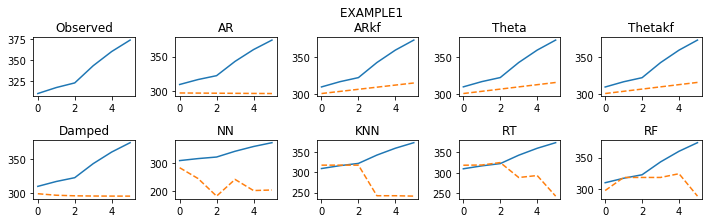

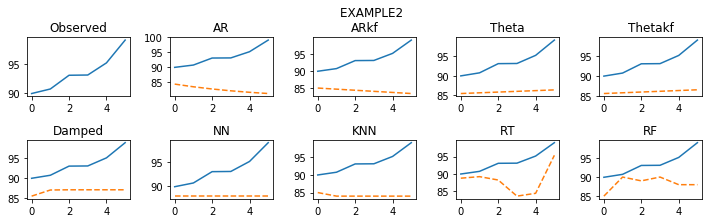

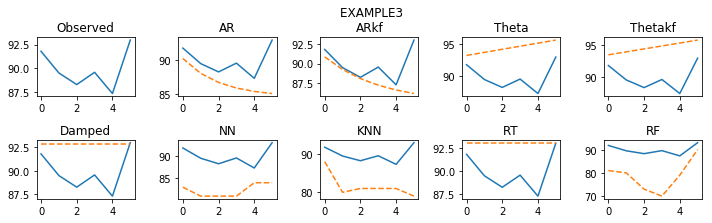

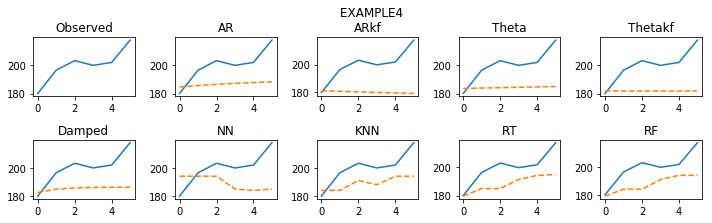

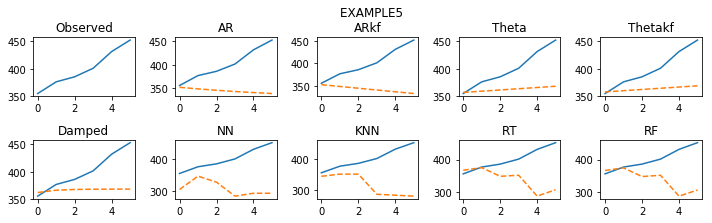

In [4]:
x = np.linspace(0, steps-1, steps)
for q in range(5):
    plt.figure(figsize=[10, 3])
    plt.tight_layout()
    plt.suptitle('        EXAMPLE' + str(q + 1), y=1.02)
    plt.subplot(2, 5, 1)
    plt.plot(x, np.array(MM.iloc[q][-steps:]))
    plt.title('Observed')
    for i in range(mcount):
        plt.subplot(2, 5, i+2)
        plt.plot(x, np.array(MM.iloc[q][-steps:]), x, locals()['ForecastMethod' + str(i+1)][q], '--')
        plt.title(mlist[i])
        plt.tight_layout()
plt.show()

## 总结
由MAPE和MASE值，发现**SSOE情况下的Theta模型**和**回归树模型（RT）**对该数据集有着较好的预测结果